In [50]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import quad
from scipy.special import sph_harm

In [6]:
G = 6.67430e-11 # m^3 kg^-1 s^-2
M = 1e12 # kg

# Multipole Expansion

I want to test the multipole expansion in approximating gravitational potentials. As an example I will first take the Satoh analytic potential and density and then approximate it with the multipole expansion. 

In [65]:
a = 0.1
b = 1

In [66]:
def Phi_s(R, z):
    S = np.sqrt(R**2 + z**2 + a*(a+2*np.sqrt(z**2 + b**2)))
    return -G*M/S

def rho_s(R, z):
    S = np.sqrt(R**2 + z**2 + a*(a+2*np.sqrt(z**2 + b**2)))
    return ( (a*b**2*M) / 4*np.pi*S**3*(z**2 + b**2)) * ( (1/(np.sqrt(z**2 + b**2))) + (3/a)*( 1 - (R**2+z**2)/S**2 ) )

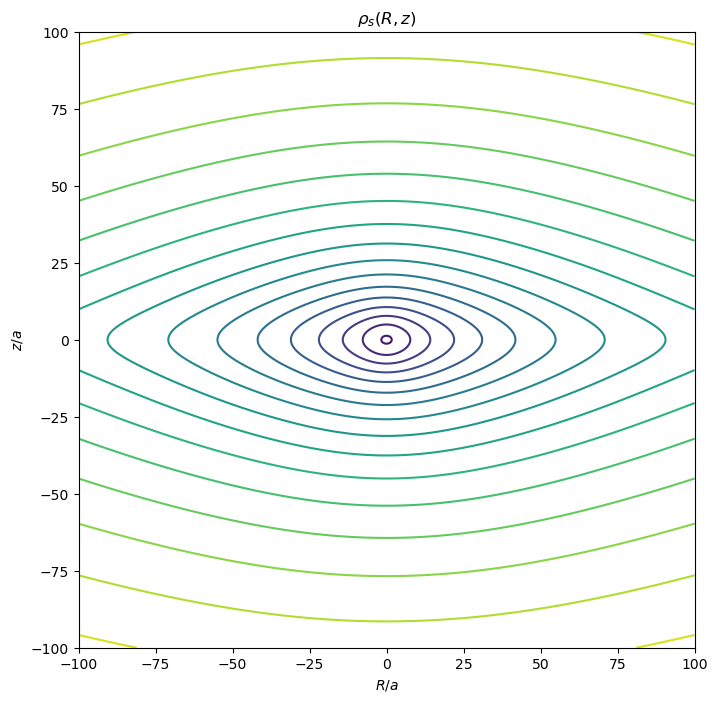

In [68]:
R_list = np.linspace(-10, 10, 500)
z_list = np.linspace(-10, 10, 500)

R, z = np.meshgrid(R_list, z_list)

density = rho_s(R, z)

R_norm = R / a
z_norm = z / a

plt.figure(figsize=(8, 8))
plt.contour(R_norm, z_norm, np.log10(density), levels=15, cmap='viridis')
plt.xlabel(r'$R/a$')
plt.ylabel(r'$z/a$')
plt.title(r'$\rho_s(R, z)$')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()



The multipole expansion is

$$ \Phi(r,\Omega) = -4\pi G \sum_{\ell,m} \frac{Y_\ell^m(\Omega)}{2\ell+1}\left(\frac{1}{r^{\ell+1}} \int_0^r da a^{\ell+2}\rho_{\ell m}(a) + r^\ell \int_r^\infty \frac{da}{a^{\ell-1}}\rho_{\ell m}(a)\right)$$

In [69]:
# Function to calculate the density in spherical coordinates
def rho_s_spherical(r, theta):
    # Convert spherical coordinates to cylindrical
    R = r * np.sin(theta)
    z = r * np.cos(theta)
    return rho_s(R, z)

def density_multipole_approx(R, z, l_max):
    r = np.sqrt(R**2 + z**2)  # Convert cylindrical coordinates to spherical
    density_approx = 0.0

    for l in range(l_max + 1):
        for m in range(-l, l + 1):
            Y_lm = sph_harm(m, l, 0, np.arctan2(R, z))  # Evaluate at φ = 0
            
            # Integral for the inner part
            integral_inner = quad(lambda a: a**(l + 2) * rho_s(a, z), 1e-3, r)[0]

            # Integral for the outer part with a finite upper limit
            outer_limit = 100
            integral_outer = quad(lambda a: rho_s(a, z) / a**(l - 1), r + 1e-3, outer_limit)[0]

            # Include the -4πG factor in the approximation
            density_approx += (-4 * np.pi * G * Y_lm / (2 * l + 1)) * (
                (1 / r**(l + 1)) * integral_inner + r**l * integral_outer
            )

    return density_approx

In [ ]:
# Generate values for R/a and z/a
R_a_values = np.linspace(-10, 10, 100)  # R/a range
z_a_values = np.linspace(-10, 10, 100)  # z/a range
R_a, z_a = np.meshgrid(R_a_values, z_a_values)

# Compute densities for the Satoh model and multipole approximation
satoh_density = np.array([[rho_s(R * a, z * a) for z in z_a_values] for R in R_a_values])
multipole_density = np.array([[density_multipole_approx(R * a, z * a, l_max=3) for z in z_a_values] for R in R_a_values])

# Plotting the contours for Satoh density
plt.figure(figsize=(12, 6))
plt.contour(R_a, z_a, satoh_density, levels=50, cmap='viridis')
plt.colorbar(label='Density (Satoh)')
plt.title('Contour Plot of Satoh Density in R/a and z/a')
plt.xlabel('R/a')
plt.ylabel('z/a')
plt.grid()
plt.show()

# Plotting the contours for Multipole density approximation
plt.figure(figsize=(12, 6))
plt.contour(R_a, z_a, multipole_density, levels=50, cmap='plasma')
plt.colorbar(label='Density (Multipole Approximation)')
plt.title('Contour Plot of Multipole Density Approximation in R/a and z/a')
plt.xlabel('R/a')
plt.ylabel('z/a')
plt.grid()
plt.show()